In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import gym

In [4]:
env = gym.make("CartPole-v1")

In [8]:
class REINFORCE:
  def __init__(self, env, path=None):
    self.env=env #import env
    self.state_shape=env.observation_space.shape # the state space
    self.action_shape=env.action_space.n # the action space
    self.gamma=0.99 # decay rate of past observations
    self.alpha=1e-4 # learning rate in the policy gradient
    self.learning_rate=0.01 # learning rate in deep learning
    
    if not path:
      self.model=self._create_model() #build model
    else:
      self.model=self.load_model(path) #import model

    # record observations
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.discounted_rewards=[]
    self.total_rewards=[]

  def hot_encode_action(self, action):
    '''encoding the actions into a binary list'''

    action_encoded=np.zeros(self.action_shape, np.float32)
    action_encoded[action]=1

    return action_encoded
  
  def remember(self, state, action, action_prob, reward):
    '''stores observations'''
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  def _create_model(self):
    ''' builds the model using keras'''
    model=keras.Sequential()

    # input shape is of observations
    model.add(keras.layers.Dense(24, input_shape=self.state_shape, activation="relu"))
    # add a relu layer 
    model.add(keras.layers.Dense(12, activation="relu"))

    # output shape is according to the number of action
    # The softmax function outputs a probability distribution over the actions
    model.add(keras.layers.Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy",
            optimizer=keras.optimizers.Adam(lr=self.learning_rate))
        
    return model

  def get_action(self, state):
    '''samples the next action based on the policy probabilty distribution 
      of the actions'''

    # transform state
    state=state.reshape([1, state.shape[0]])
    # get action probably
    action_probability_distribution=self.model.predict(state).flatten()
    # norm action probability distribution
    action_probability_distribution/=np.sum(action_probability_distribution)
    
    # sample action
    action=np.random.choice(self.action_shape,1,
                            p=action_probability_distribution)[0]

    return action, action_probability_distribution

  def get_discounted_rewards(self, rewards): 
    '''Use gamma to calculate the total reward discounting for rewards
    Following - \gamma ^ t * Gt'''
    
    discounted_rewards=[]
    cumulative_total_return=0
    # iterate the rewards backwards and and calc the total return 
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-7) # avoiding zero div
    
    return norm_discounted_rewards

  def update_policy(self):
    '''Updates the policy network using the NN model.
    This function is used after the MC sampling is done - following
    \delta \theta = \alpha * gradient + log pi'''
      
    # get X
    states=np.vstack(self.states)

    # get Y
    gradients=np.vstack(self.gradients)
    rewards=np.vstack(self.rewards)
    discounted_rewards=self.get_discounted_rewards(rewards)
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.probs

    history=self.model.train_on_batch(states, gradients)
    
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []

    return history

  def train(self, episodes, rollout_n=1, render_n=50):
    '''train the model
        episodes - number of training iterations 
        rollout_n- number of episodes between policy update
        render_n - number of episodes between env rendering ''' 
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      # each episode is a new game env
      state=env.reset()
      done=False          
      episode_reward=0 #record episode reward
      
      while not done:
        # play an action and record the game state & reward per episode
        action, prob=self.get_action(state)
        next_state, reward, done, _=env.step(action)
        self.remember(state, action, prob, reward)
        state=next_state
        episode_reward+=reward

        #if episode%render_n==0: ## render env to visualize.
          #env.render()
        if done:
          # update policy 
          if episode%rollout_n==0:
            history=self.update_policy()

      total_rewards[episode]=episode_reward
      if episode%10==0:
        print(f"{episode} -> {episode_reward}")
      
    self.total_rewards=total_rewards

<>:74: DeprecationWarning: invalid escape sequence \g
<>:93: DeprecationWarning: invalid escape sequence \d


In [9]:
r = REINFORCE(env)

r.train(200)

c:\winapp\Miniconda3\envs\py38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0 -> 39.0
10 -> 50.0
20 -> 18.0
30 -> 15.0
40 -> 16.0
50 -> 17.0
60 -> 20.0
70 -> 11.0
80 -> 20.0
90 -> 40.0
100 -> 36.0
110 -> 18.0
120 -> 79.0
130 -> 43.0
140 -> 41.0
150 -> 37.0
160 -> 95.0
170 -> 72.0
180 -> 138.0
190 -> 102.0


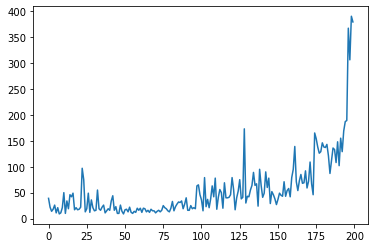

In [10]:
plt.plot(r.total_rewards)